# Toroidal Beta VAE Model Testing Framework

In [1]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

Added project root: /notebooks


# Hyperparameters

In [2]:
import torch

#### deterministic run ####

determinism_kwargs = None

# determinism_kwargs = {
#     'seed':0,
#     'use_cuda_det': True,
#     'enforce_det':False,
#     'cublas_workspace_config': None,
# }

##### Model parameters #####
model_name = 'toroidal_vae_locatello'  # Name of the toroidal VAE architecture file
model_decoder_output_dist = 'bernoulli'  # Output distribution of the decoder (e.g., 'bernoulli', 'gaussian')
latent_factor_num = 6
use_torch_compile = False  # Use torch.compile for model compilation (requires PyTorch 2.0 or higher)

#### Training parameters ####
train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 5

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

learning_rate = 1e-4
batch_size = 64

#### losses ####
loss_name = 'beta_toroidal_vae'      # Type of loss for toroidal VAE
loss_kwargs = {
    'beta': 16,
    'rec_dist': 'bernoulli',  # Reconstruction distribution ('bernoulli', 'gaussian')
    'log_kl_components':True,
    'schedulers_kwargs': [
    {
        'name': 'cyclical',
        'kwargs': {
            'param_name': 'beta',
            'initial_value': 0.0,  # Start with no meaningful loss
            'final_value': 16,  # End with full meaningful loss
            'total_steps': 30000,
            'n_cycle': 2,
            'ratio': 0.8
        }
    }
]
}

#### device parameters ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU")
else:
    print("Using CPU")

### Checkpoint parameters ###
return_chkpt = False
chkpt_every_n_steps=2400

# chkpt_save_path = 'checkpoints/tests/test-epoch-1.pt'
chkpt_save_path = None

chkpt_save_dir = None
# chkpt_save_dir = 'checkpoints/toroidal_tests_1'

chkpt_save_master_dir=None
chkpt_viz = True

Using GPU


# Reproducibility

In [3]:
if determinism_kwargs is not None:
    # MUST Be set before importing any other modules
    # to ensure reproducibility across all libraries
    from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader
    set_deterministic_run(**determinism_kwargs)
    print(f"Set deterministic run with kwargs: {determinism_kwargs}")

# Imports

In [4]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

# Shapes3d

## Load dataset

In [5]:
# Load 3D Shapes
Shapes3D = get_dataset("shapes3d")
shapes3d_dataset = Shapes3D(selected_factors='all', not_selected_factors_index_value=None)

# num_workers_3dshapes = find_optimal_num_workers(shapes3d_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_3dshapes = 4

if determinism_kwargs is not None:
    shapes3d_dataloader = get_deterministic_dataloader(dataset=shapes3d_dataset, 
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_3dshapes,
                                                   seed=determinism_kwargs['seed'],
                                                   pin_memory=True)
else:
    shapes3d_dataloader = torch.utils.data.DataLoader(shapes3d_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_3dshapes, 
                                                      shuffle=True, 
                                                      pin_memory=True)


print(f"Loaded 3D Shapes dataset with {len(shapes3d_dataset)} samples.")

Loaded 3D Shapes dataset with 480000 samples.


## Setup Model, Loss, and Optimizer

In [6]:
def setup_components(dataset, loss_kwargs):
    """Instantiates toroidal VAE model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    

    # Instantiate Toroidal VAE Model
    model = vae_models.select(name=model_name, 
                              img_size=img_size, 
                              latent_factor_num=latent_factor_num, 
                              decoder_output_dist=model_decoder_output_dist
                              ).to(device)

    # For toroidal VAE losses, no special handling needed for beta_toroidal_vae
    # but kept the structure for potential future extensions
    if 'betatc' in loss_name.lower():
        loss_kwargs['n_data'] = n_data
    
    loss_fn = losses.select(loss_name, **loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.model_name}")
    print(f"Loss: {loss_fn.name} (rec_dist={loss_kwargs['rec_dist']}), kwargs={loss_kwargs}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"---------------------------")

    return model, loss_fn, optimizer

## Train

In [7]:
shapes3d_loss_kwargs = loss_kwargs.copy()
shapes3d_loss_kwargs.update({'beta': 5})

In [8]:
print("\n===== Training Toroidal Beta VAE on 3D Shapes =====")
model_3dshapes, loss_fn_3dshapes, optimizer_3dshapes = setup_components(shapes3d_dataset, shapes3d_loss_kwargs)

trainer_3dshapes = UnsupervisedTrainer(model=model_3dshapes,
                                      loss=loss_fn_3dshapes,
                                      optimizer=optimizer_3dshapes,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_logs=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      chkpt_save_dir=chkpt_save_dir,
                                      chkpt_every_n_steps=chkpt_every_n_steps,
                                      chkpt_viz=chkpt_viz
                                      )

trainer_3dshapes.train(step_unit=train_step_unit, max_steps=num_train_steps, dataloader=shapes3d_dataloader)


===== Training Toroidal Beta VAE on 3D Shapes =====
--- Setup for Shapes3D --- 
Model: toroidal_vae_locatello
Loss: beta_toroidal_vae (rec_dist=bernoulli), kwargs={'beta': 5, 'rec_dist': 'bernoulli', 'log_kl_components': True, 'schedulers_kwargs': [{'name': 'cyclical', 'kwargs': {'param_name': 'beta', 'initial_value': 0.0, 'final_value': 16, 'total_steps': 30000, 'n_cycle': 2, 'ratio': 0.8}}]}
Optimizer: Adam
---------------------------


{'logs': {'train_losses_log': [{'loss': 7870.1665942382815,
    'rec_loss': 7868.871062011719,
    'kl_loss': 7.914203186035156,
    'kl_loss_0': 0.028503419160842897,
    'kl_loss_1': 1.6093321573734283,
    'kl_loss_2': 1.4276684009283782,
    'kl_loss_3': 1.660992493033409,
    'kl_loss_4': 1.5685865259170533,
    'kl_loss_5': 1.6191201651841403,
    'iter': 200,
    'epoch': 0.02666666666666667},
   {'loss': 6765.741840820312,
    'rec_loss': 6760.423784179688,
    'kl_loss': 13.126832728385926,
    'kl_loss_0': 1.6466895213723183,
    'kl_loss_1': 2.256157038807869,
    'kl_loss_2': 2.220052293539047,
    'kl_loss_3': 2.31287349820137,
    'kl_loss_4': 2.385283582210541,
    'kl_loss_5': 2.305776824951172,
    'iter': 400,
    'epoch': 0.05333333333333334},
   {'loss': 6076.472421875,
    'rec_loss': 6065.876967773437,
    'kl_loss': 15.884391961097718,
    'kl_loss_0': 2.1855873429775237,
    'kl_loss_1': 2.711471908092499,
    'kl_loss_2': 2.681269837617874,
    'kl_loss_3': 2.7

### Visualization

In [11]:
# Use SVAEVisualizer for toroidal VAE models
visualizer_3dshapes = utils.visualize.SVAEVisualizer(vae_model=model_3dshapes, dataset=shapes3d_dataset)

#### Reconstructions

Plotting random reconstructions...


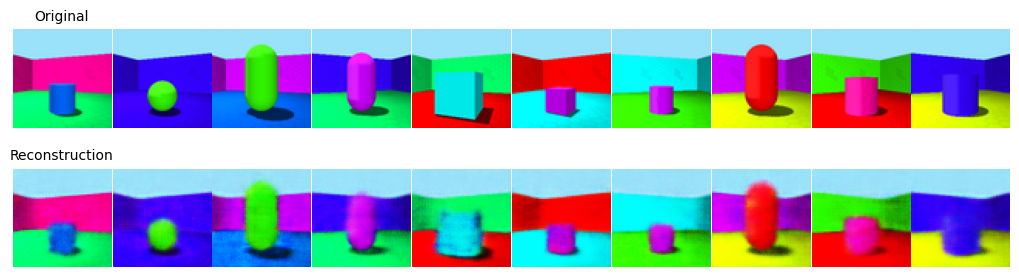

Plotting reconstructions from specific indices...


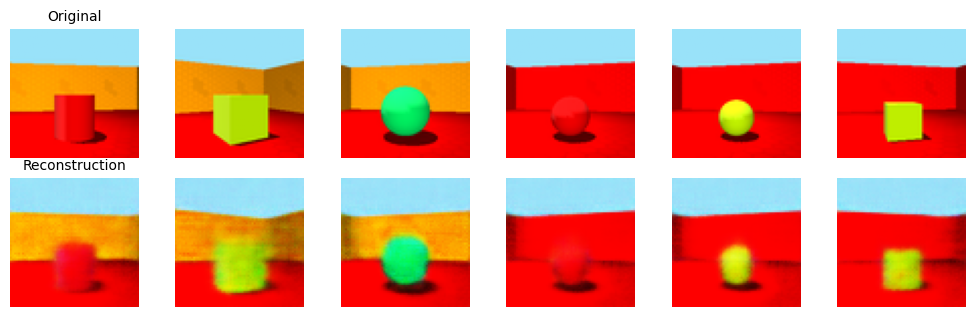

In [12]:
print("Plotting random reconstructions...")
visualizer_3dshapes.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_3dshapes = [5000, 6000, 7000, 100, 1000, 1024] # Example indices
visualizer_3dshapes.plot_reconstructions_sub_dataset(indices_3dshapes, mode='mean')
plt.show()

#### Latent traversal

Plotting latent traversals...


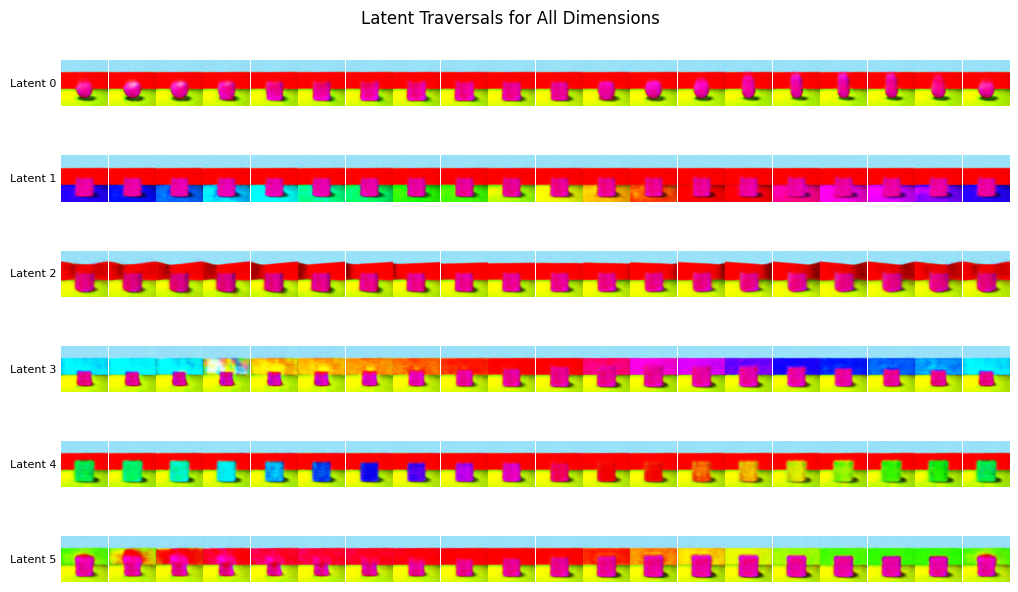

In [14]:
print("Plotting latent traversals...")
visualizer_3dshapes.plot_all_latent_traversals(num_samples=20,
                                               max_traversal_type='fraction',
                                               max_traversal=1,
                                               )
plt.show()

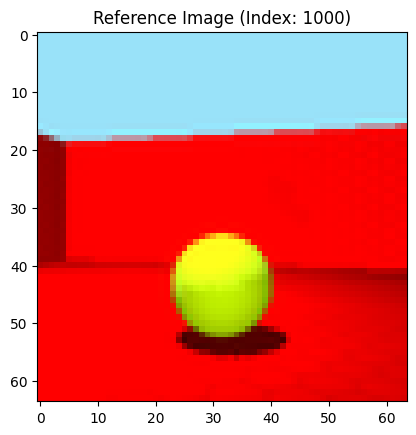

In [15]:
ref_img_idx = 1000
ref_img = shapes3d_dataset[ref_img_idx][0]
plt.imshow(ref_img.permute(1, 2, 0).cpu().numpy())
plt.title(f"Reference Image (Index: {ref_img_idx})")
plt.show()

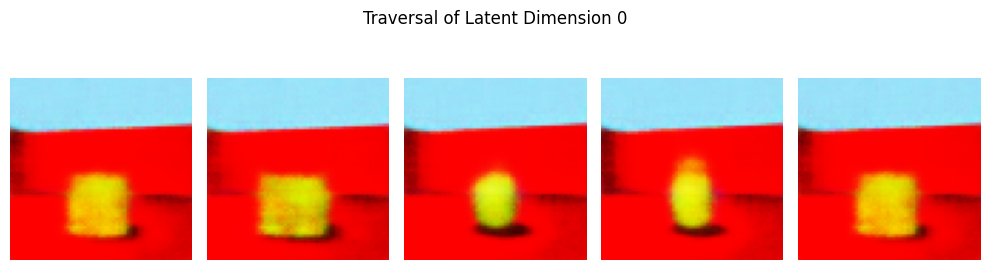

In [16]:
# single latent traversal based on the reference image
latent_idx = 0  # Index of the latent dimension to traverse
visualizer_3dshapes.plot_single_latent_traversal(latent_idx, 
                                                 ref_img=ref_img, 
                                                 num_samples=5,
                                                 max_traversal_type='fraction', 
                                                 max_traversal=1)

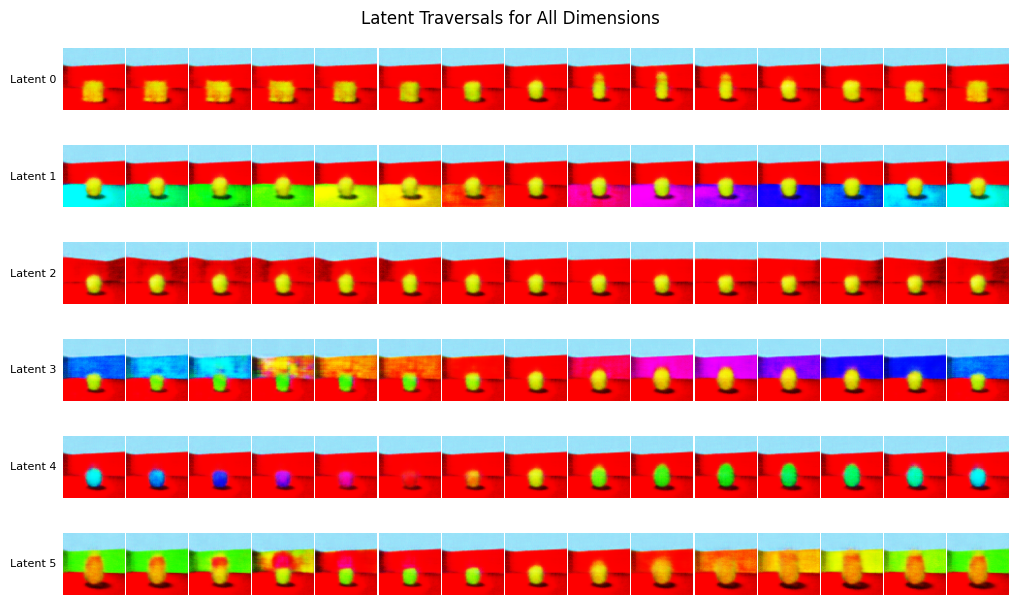

In [17]:
visualizer_3dshapes.plot_all_latent_traversals(ref_img=ref_img, 
                                               num_samples=15,  
                                               max_traversal_type='fraction',
                                               max_traversal=1
                                               )

## Metric Evaluation

In [ ]:
metrics_to_compute = [
    {'name': 'dci_d', 'args':{'num_train':5000, 'num_test':1000}}, # Added num_train and num_test
    {'name': 'mig', 'args':{}} # MIG uses default args (num_bins=20, num_workers=8, etc.)
]

metric_aggregator_3dshapes = MetricAggregator(metrics=metrics_to_compute)

print("\n===== Computing Metrics for 3D Shapes (Toroidal Beta VAE) =====")
metrics_results_3dshapes = metric_aggregator_3dshapes.compute(model=model_3dshapes, 
                                                              data_loader=shapes3d_dataloader, 
                                                              device=device)
print("3D Shapes Metrics:", metrics_results_3dshapes)

# dSprites

In [ ]:
# Load dSprites
Dsprites = get_dataset('dsprites')

dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

if determinism_kwargs is not None:
    dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=determinism_kwargs['seed'],
                                                   pin_memory=True)
else:
    dsprites_dataloader = torch.utils.data.DataLoader(dsprites_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_dsprites, 
                                                      shuffle=True, 
                                                      pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

## Train

In [ ]:
# Toroidal Beta VAE for dSprites
loss_kwargs_toroidal_beta_vae_dsprites =  {
    'beta': 16,
    'rec_dist': 'bernoulli', # Use bernoulli for dSprites
    'log_kl_components':True
               }

In [ ]:
print("\n===== Training Toroidal Beta VAE on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, loss_kwargs_toroidal_beta_vae_dsprites)

trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                                      loss=loss_fn_dsprites,
                                      optimizer=optimizer_dsprites,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_logs=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      chkpt_save_dir=chkpt_save_dir,
                                      chkpt_every_n_steps=chkpt_every_n_steps,
                                      chkpt_viz=chkpt_viz
                                      )
trainer_dsprites.train(max_steps=num_train_steps, step_unit=train_step_unit, dataloader=dsprites_dataloader)

In [ ]:
print("\n===== Visualizing dSprites Results (Toroidal Beta VAE) =====")
visualizer_dsprites = utils.visualize.SVAEVisualizer(vae_model=model_dsprites, dataset=dsprites_dataset)

## Visualization

### Reconstructions

In [ ]:
print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 100000, 200000, 300000, 40000, 50000] # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

### Latent traversal

In [ ]:
print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=20,
                                               max_traversal_type='fraction',
                                               max_traversal=1
                                               )
plt.show()

In [ ]:
# Select a reference image index for dSprites
ref_img_idx_dsprites = 10000  # Example index
ref_img_dsprites = dsprites_dataset[ref_img_idx_dsprites][0]

# Plot the reference image
plt.imshow(ref_img_dsprites.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"dSprites Reference Image (Index: {ref_img_idx_dsprites})")
plt.show()

In [ ]:
# Single latent traversal based on the reference image
latent_idx_dsprites = 0  # Index of the latent dimension to traverse
print(f"Plotting single latent traversal for dimension {latent_idx_dsprites}...")
visualizer_dsprites.plot_single_latent_traversal(latent_idx_dsprites, ref_img=ref_img_dsprites, num_samples=5,
                                                 max_traversal_type='fraction',
                                                 max_traversal=1)
plt.show()

In [ ]:
# All latent traversals based on the reference image
print("Plotting all latent traversals based on reference image...")
visualizer_dsprites.plot_all_latent_traversals(ref_img=ref_img_dsprites,
                                               num_samples=15,  
                                               max_traversal_type='fraction',
                                               max_traversal=1
                                               )
plt.show()

## Metric Evaluation (dSprites)

In [ ]:
print("\n===== Computing Metrics for dSprites (Toroidal Beta VAE) =====")
metric_aggregator_dsprites = MetricAggregator(metrics=metrics_to_compute)

metrics_results_dsprites = metric_aggregator_dsprites.compute(model=model_dsprites, 
                                                            data_loader=dsprites_dataloader, 
                                                            device=device)
print("dSprites Metrics:", metrics_results_dsprites)